<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
Month            100000 non-null object
DayofMonth       100000 non-null object
DayOfWeek        100000 non-null object
DepTime          100000 non-null int64
UniqueCarrier    100000 non-null object
Origin           100000 non-null object
Dest             100000 non-null object
Distance         100000 non-null int64
dtypes: int64(2), ob

(None, None)

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [4]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [5]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [6]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

In [7]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train = train.drop('dep_delayed_15min', axis=1)
X = pd.concat([X_train, test])

In [8]:
X.describe()

,DepTime,Distance
count,200000.000000,200000.000000
mean,1340.230240,726.263635
std,478.471381,568.955768
min,1.000000,30.000000
25%,930.000000,319.000000
50%,1329.000000,575.000000
75%,1733.000000,954.000000
max,2534.000000,4962.000000


In [9]:
X.describe(include='object')

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest
count,200000,200000,200000,200000,200000,200000
unique,12,31,7,23,307,307
top,c-8,c-19,c-1,WN,ATL,ATL
freq,17727,6730,29586,30958,11387,11382


In [10]:
X.Month = X.Month.str[2:].astype('int')
X.DayofMonth = X.DayofMonth.str[2:].astype('int')
X.DayOfWeek = X.DayOfWeek.str[2:].astype('int')

In [11]:
X.describe()

,Month,DayofMonth,DayOfWeek,DepTime,Distance
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,6.530710,15.702585,3.942155,1340.230240,726.263635
std,3.415164,8.792117,1.991469,478.471381,568.955768
min,1.000000,1.000000,1.000000,1.000000,30.000000
25%,4.000000,8.000000,2.000000,930.000000,319.000000
50%,7.000000,16.000000,4.000000,1329.000000,575.000000
75%,9.000000,23.000000,6.000000,1733.000000,954.000000
max,12.000000,31.000000,7.000000,2534.000000,4962.000000


In [14]:
X_train = X[:X_train.shape[0]]
X_train['delayed'] = y_train

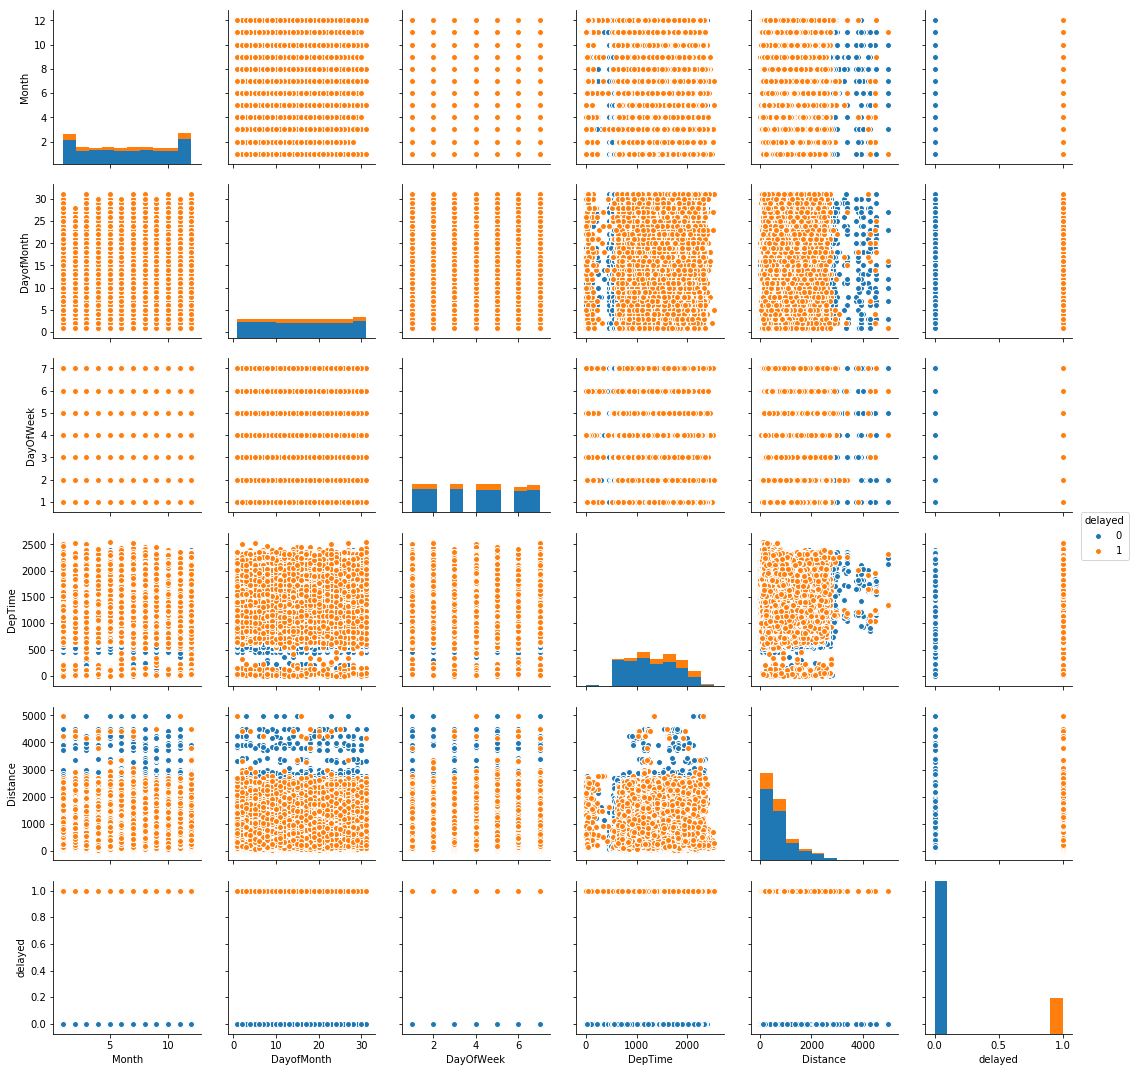

In [22]:
sns.pairplot(X_train, hue='delayed')

In [15]:
X_train['is_weekend'] = X_train['DayOfWeek'].isin([6,7])*1

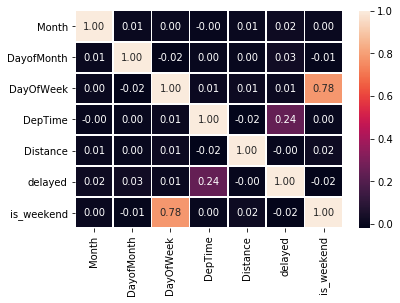

In [16]:

corr_m = X_train.corr()
sns.heatmap(corr_m, annot=True, fmt=".2f", linewidths=.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001E47E588>,
      dtype=object)

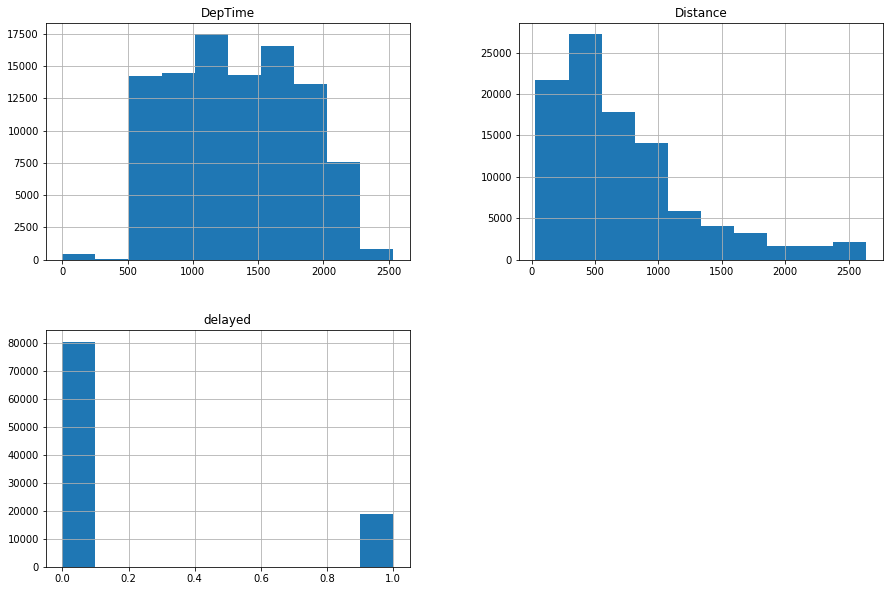

In [102]:
X_train.hist(figsize=(15, 10), bins=10)

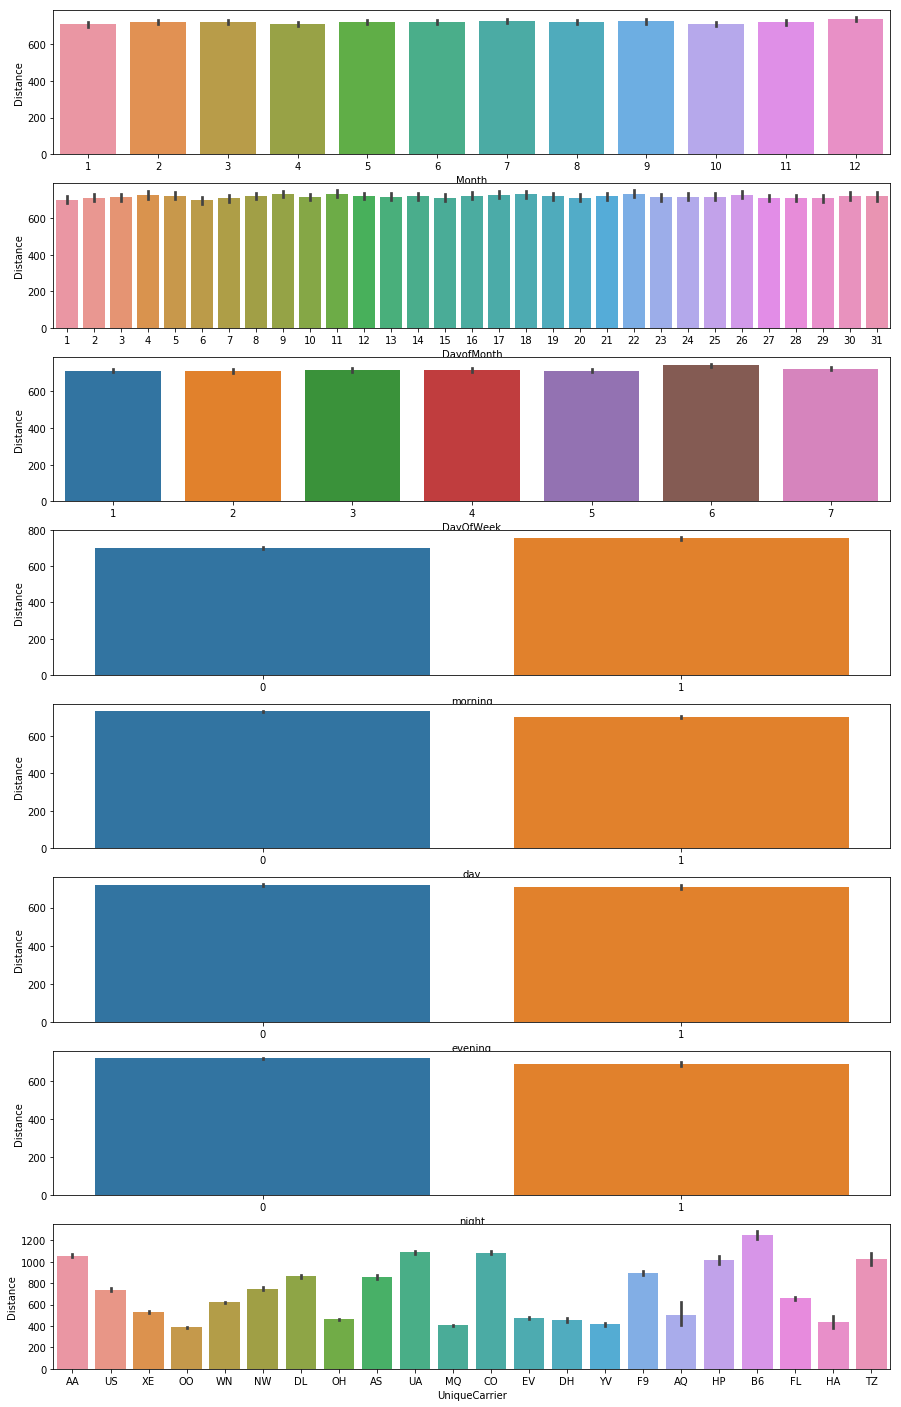

In [112]:

# X_train['Dist_cat'] = pd.cut(X_train.Distance, bins=10)
# X_train['DepTime_cat'] = pd.cut(X_train.DepTime, bins=10)
# X_train['route'] = X_train['Origin'] + X_train['Dest']
categories = ['Month', 'DayofMonth', 'DayOfWeek', 'morning', 'day', 'evening', 'night', 'UniqueCarrier']

f, axarr = plt.subplots(ncols=1, nrows=len(categories), figsize=(15, 25))

i = 0
for cat in categories:
    sns.barplot(x=cat, y='Distance', data=train_tr, ax=axarr[i])
#     axarr[i,1].set_xlim([0, 400])
#     sns.barplot(y=cat, x='ClaimAmount', data=t_comp_ds, ax=axarr[i,1])
    i += 1

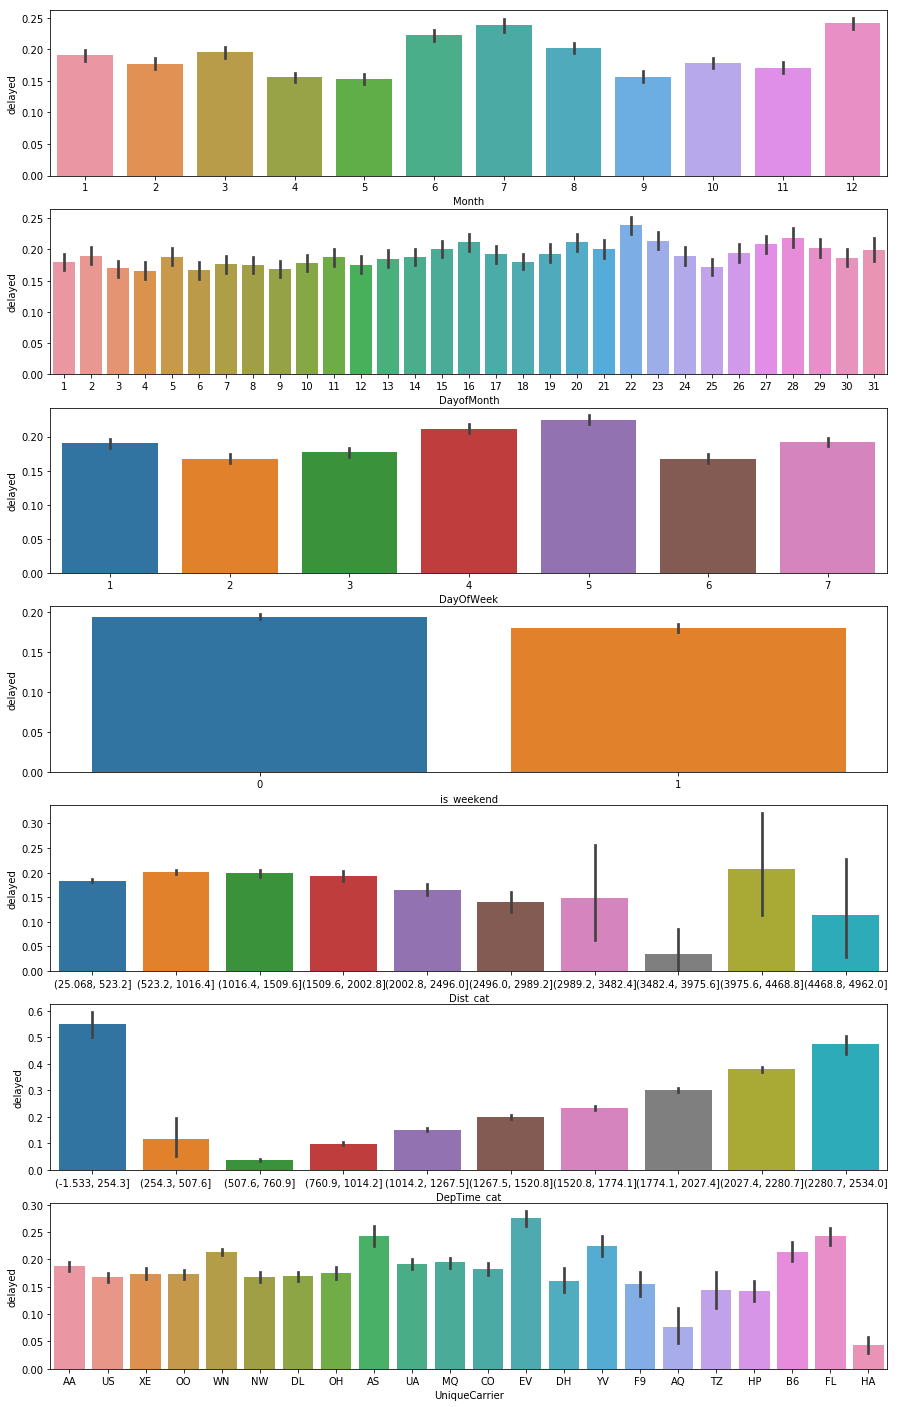

In [18]:

X_train['Dist_cat'] = pd.cut(X_train.Distance, bins=10)
X_train['DepTime_cat'] = pd.cut(X_train.DepTime, bins=10)
X_train['route'] = X_train['Origin'] + X_train['Dest']
categories = ['Month', 'DayofMonth', 'DayOfWeek', 'is_weekend', 'Dist_cat', 'DepTime_cat', 'UniqueCarrier']

f, axarr = plt.subplots(ncols=1, nrows=len(categories), figsize=(15, 25))

i = 0
for cat in categories:
    sns.barplot(x=cat, y='delayed', data=X_train, ax=axarr[i])
#     axarr[i,1].set_xlim([0, 400])
#     sns.barplot(y=cat, x='ClaimAmount', data=t_comp_ds, ax=axarr[i,1])
    i += 1

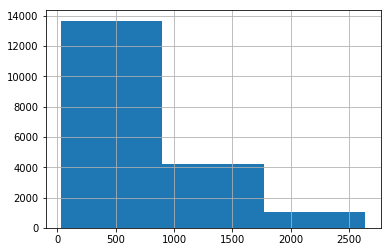

In [278]:
X_train.Distance[X_train.delayed == 1].hist(bins=3)

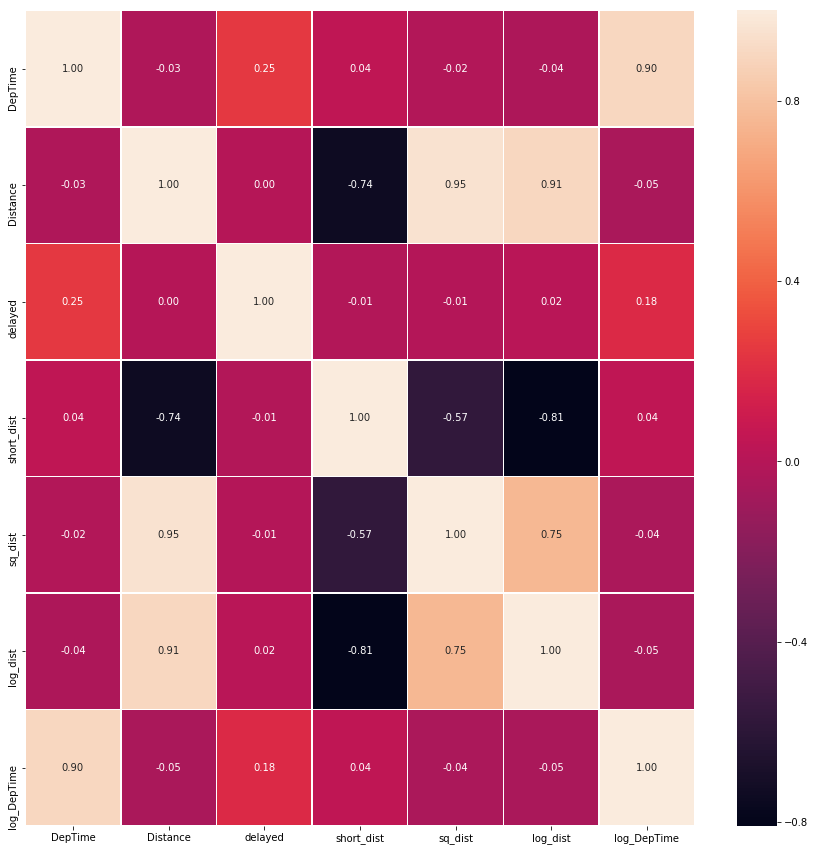

In [282]:
X_train['log_DepTime'] = np.log(X_train.DepTime)
corr_m = X_train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_m, annot=True, fmt=".2f", linewidths=.5)

In [59]:
X_train.drop(X_train.columns[X_train.dtypes == 'object'], axis=1, inplace=True)
# X_train.drop(['delayed'], axis=1, inplace=True)
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

lr_s = LogisticRegression(C=100, class_weight='balanced')

lr_s.fit(Xt, yt)

lr_s_pred = lr_s.predict_proba(Xv)[:, 1]

roc_auc_score(yv, lr_s_pred)

0.6946142283233573

In [64]:

import xgboost as xgb


# lb = LabelBinarizer()

# X_train_lb = X_train.copy()

# X_train_lb['OrDest'] = X_train_lb['Origin'] + '_' + X_train_lb['Dest']
# X_train_lb.drop(['Origin', 'Dest'], axis=1, inplace=True)

# for col in X_train_lb.columns[X_train_lb.dtypes =='object']:
#     X_train_lb[col] = lb.fit_transform(X_train_lb[col])
    
# X_tr, X_val, y_tr, y_val = train_test_split(X_train_lb, y_train, test_size=0.3, random_state=17)

dtrain = xgb.DMatrix(Xt, label=yt)
dtest = xgb.DMatrix(Xv)

params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'nthread': 8,
#     'booster': 'dart',
#     'eta':0.05,
#     'gamma': 0.5,
    'lambda': 100,
#     'alpha': 0.05
}

num_rounds = 500
xgb_ = xgb.train(params, dtrain, num_rounds)

xgb__pred = xgb_.predict(dtest)

roc_auc_score(yv, xgb__pred)

0.7353157375418252

In [49]:
X_train.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'delayed',
       'is_weekend', 'route_mean_target', 'UniqueCarrier_mean_target',
       'Origin_mean_target', 'Dest_mean_target', 'uc_route_mean_target',
       'uc_o_mean_target', 'uc_d_mean_target'],
      dtype='object')

In [120]:
def get_f_waight(dfkey, dict_):
    if (key in dict_):
        return dict_[key]
    else:
        return 0.5

In [3]:
def mean_target_enc(train_df, y_train, valid_df, cat_features, skf):
    import warnings
    warnings.filterwarnings('ignore')
    target_name = y_train.name
    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()  

    for col in cat_features:
        new_train_df[col + '_mean_' + target_name] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_' + target_name] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_' + target_name] = means.fillna(glob_mean)
        
#     valid_df.drop(cat_features, axis=1, inplace=True)
    
    return new_train_df, valid_df

In [32]:

def prepare_data(df):
    new_df = df.copy()
#     new_df['Month'] = new_df['Month'].str[2:].astype('int')
#     new_df['DayofMonth'] = new_df['DayofMonth'].str[2:].astype('int')
    dow = new_df['DayOfWeek'].str[2:].astype('int')
    new_df['Route'] = new_df['Origin'] + '-' + new_df['Dest']
    new_df['UCR'] = new_df['UniqueCarrier'] + '-' + new_df['Route']
#     new_df.drop(['Origin', 'Dest'], axis=1, inplace=True)
    
#     dep_time =  pd.cut(df['DepTime'], bins=[-1, 250, 500,750, 1000, 1250, 1500, 1750, 2000, 2250, 2535]).astype('str')
    
#     dist = pd.cut(df['Distance'], bins=[1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]).astype('str') 
    
    is_we = dow.isin([6,7]).astype('int')
    
    new_df['is_weekend'] = is_we
    new_df['DepTime'] = new_df['DepTime'] % 2400
    
    hour = (new_df['DepTime'] / 100).astype('int')
    new_df['Hour'] = hour
    new_df['minutes'] = (new_df['DepTime'] % 100).astype('int')
    new_df.drop(['DepTime'], axis=1, inplace=True)
    
    new_df = pd.get_dummies(new_df, columns=['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest'])
#     new_df[new_df.columns[new_df.columns.str.startswith('Dest_')]] = new_df[new_df.columns[new_df.columns.str.startswith('Dest_')]]*(-1)
    
#     ohe = OneHotEncoder()
    
    return new_df
    

In [650]:
def one_hot_encoding(df_train, df_test):
    df_all = pd.concat([df_train, df_test])
    
    lb = LabelBinarizer()

    for col in df_all.columns[df_all.dtypes =='object']:
        lbc = lb.fit(df_all[col])
        
        sp_c_tr = lbc.transform(df_train[col])
        for j in range(sp_c_tr.shape[1]):
            df_train[col + str(j)] = sp_c_tr[:, j]
        
        sp_c_t = lbc.transform(df_test[col])
        for j in range(sp_c_t.shape[1]):
            df_test[col + str(j)] = sp_c_t[:, j]
        
    return df_train, df_test

In [5]:
train_clean = train[(train.Distance <= 2650 ) & (train.DepTime < 2400)]
train_clean['delayed'] = train_clean['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
y_train = train_clean['delayed']

X_train = train_clean.drop('dep_delayed_15min', axis=1)
X_test = test

route_w = dict(X_train.groupby(['Origin', 'Dest'])['delayed'].mean())

uc_w = dict(X_train.groupby('UniqueCarrier')['delayed'].mean())  

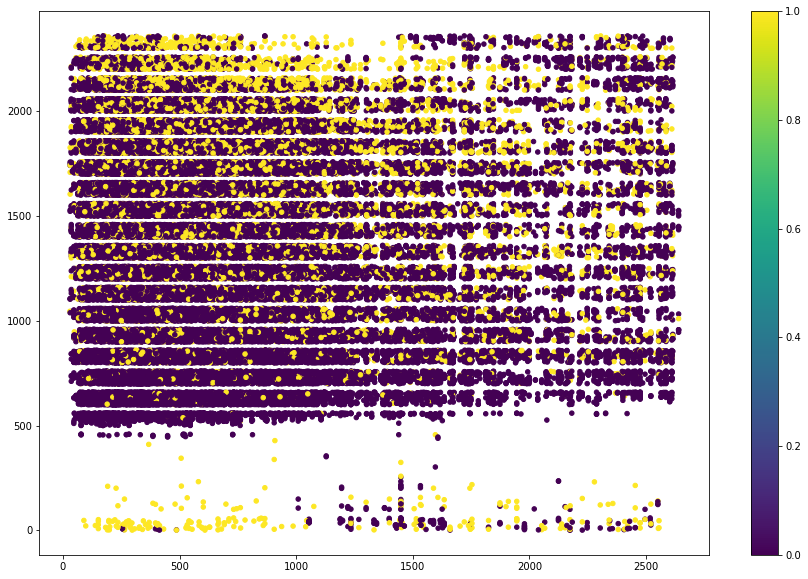

In [334]:



plt.figure(figsize=(15, 10))
plt.scatter(X_train.Distance.values, X_train.DepTime.values, c=y_train, s=20, cmap='viridis')
# plt.axvline(2650)
plt.colorbar()

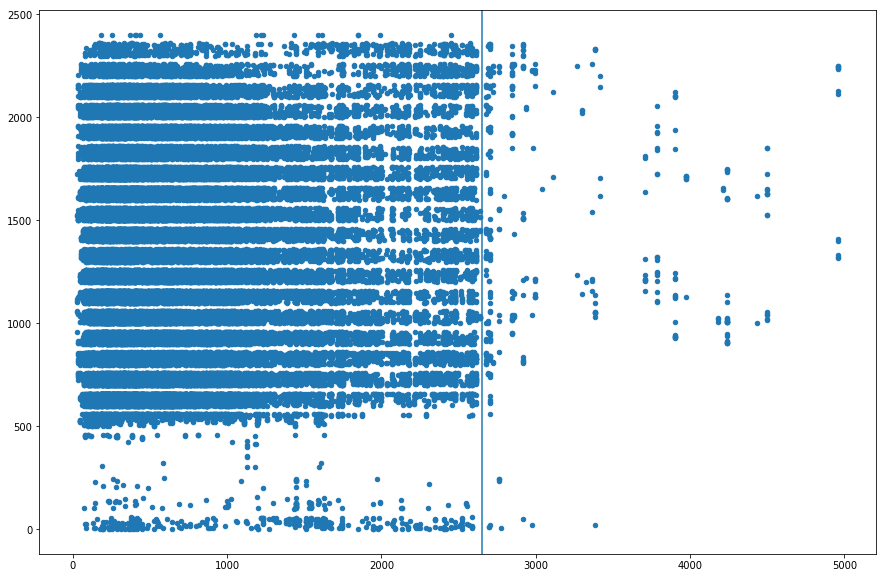

In [524]:

plt.figure(figsize=(15, 10))
plt.scatter(X_test.Distance.values, X_test.DepTime.values, s=20, cmap='viridis')
plt.axvline(2650)

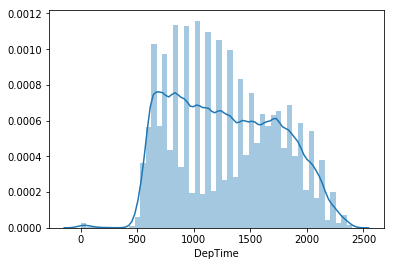

In [72]:
sns.distplot(X_train[y_train == 0].DepTime, bins=50)

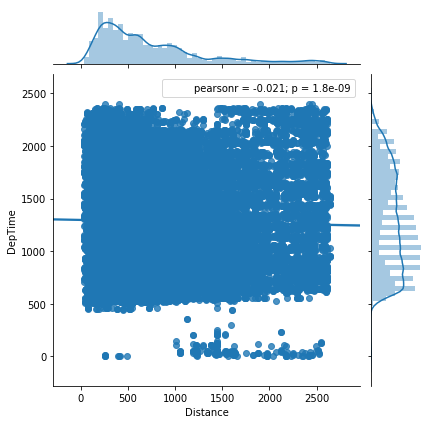

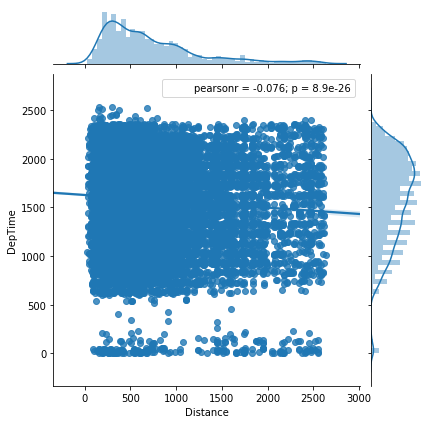

In [73]:

sns.jointplot(x='Distance', y='DepTime', data=X_train[y_train == 0], kind='reg')
sns.jointplot(x='Distance', y='DepTime', data=X_train[y_train == 1], kind='reg')

In [441]:
X_train[(X_train.DepTime % 2400 >= 500) & (X_train.Distance <= 2695)].shape

(99136, 9)

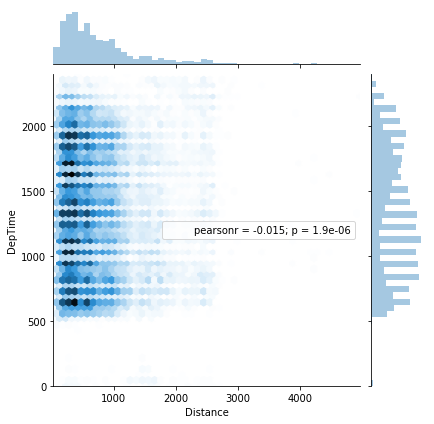

In [74]:
sns.jointplot(x='Distance', y='DepTime', data=X_test, kind='hex')

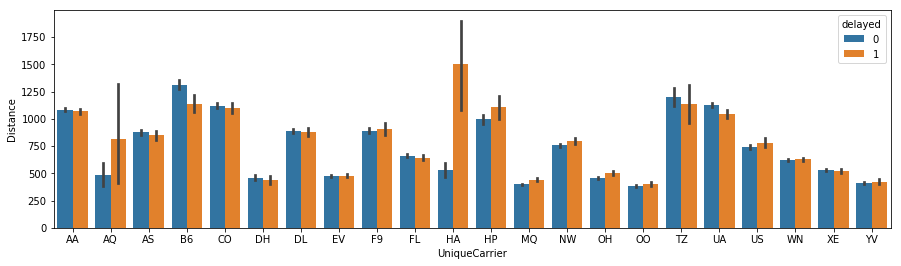

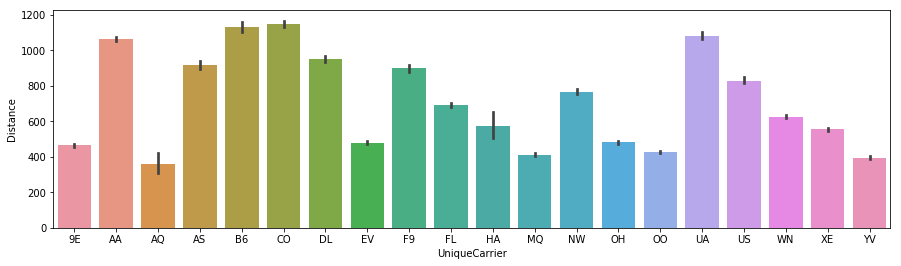

In [459]:
plt.figure(figsize=(15, 4))
sns.barplot(x='UniqueCarrier', y='Distance', hue='delayed', data=pd.concat([X_train, y_train], axis=1), order=np.sort(X_train.UniqueCarrier.unique()))
plt.figure(figsize=(15, 4))
sns.barplot(x='UniqueCarrier', y='Distance', data=X_test, order=np.sort(X_test.UniqueCarrier.unique()))

In [33]:
full_tr = prepare_data(pd.concat([X_train, X_test]))
train_tr = full_tr[:X_train.shape[0]]
test_tr = full_tr[X_train.shape[0]:]

In [310]:
test_tr.columns

Index(['Distance', 'delayed', 'is_weekend', 'Hour', 'minutes', 'Month_c-1',
       'Month_c-10', 'Month_c-11', 'Month_c-12', 'Month_c-2',
       ...
       'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH',
       'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA',
       'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE',
       'UniqueCarrier_YV'],
      dtype='object', length=692)

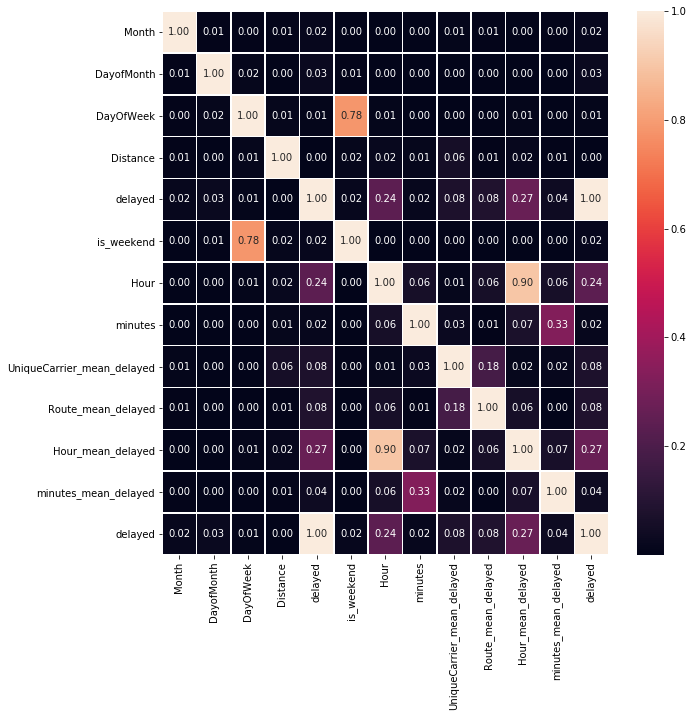

In [199]:
cr = np.abs(pd.concat([train_tr[], y_train], axis=1).corr())

plt.figure(figsize=(10, 10))
sns.heatmap(cr, annot=True, fmt=".2f", linewidths=.5)

In [34]:
train_tr, test_tr = mean_target_enc(train_tr, y_train, test_tr, ['UniqueCarrier', 'Route', 'UCR', 'Hour', 'minutes'], StratifiedKFold(n_splits=5, shuffle=True, random_state=1))

In [35]:
train_tr, test_tr = mean_target_enc(train_tr, train_tr.Distance, test_tr, ['Hour', 'UniqueCarrier', 'Route'], StratifiedKFold(n_splits=5, shuffle=True, random_state=1))

In [36]:
full_tr = pd.concat([train_tr, test_tr])
full_tr = pd.get_dummies(full_tr, columns=['UniqueCarrier'])
full_tr.drop(['Route', 'delayed'], axis=1, inplace=True)
# full_tr['Distance'] = np.log(full_tr.Distance)
train_tr = full_tr[:train_tr.shape[0]]
test_tr = full_tr[train_tr.shape[0]:]


In [39]:
full_tr.drop(['UCR'], axis=1, inplace=True)
# full_tr['Distance'] = np.log(full_tr.Distance)
train_tr = full_tr[:train_tr.shape[0]]
test_tr = full_tr[train_tr.shape[0]:]

In [40]:

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(train_tr, y_train, test_size=0.3, random_state=17)

In [41]:
train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99504 entries, 0 to 99999
Columns: 699 entries, Distance to UniqueCarrier_YV
dtypes: float64(8), int32(3), int64(1), uint8(687)
memory usage: 73.9 MB


In [46]:

import xgboost as xgb


# lb = LabelBinarizer()

# X_train_lb = X_train.copy()

# X_train_lb['OrDest'] = X_train_lb['Origin'] + '_' + X_train_lb['Dest']
# X_train_lb.drop(['Origin', 'Dest'], axis=1, inplace=True)

# for col in X_train_lb.columns[X_train_lb.dtypes =='object']:
#     X_train_lb[col] = lb.fit_transform(X_train_lb[col])
    
# X_tr, X_val, y_tr, y_val = train_test_split(X_train_lb, y_train, test_size=0.3, random_state=17)

dtrain = xgb.DMatrix(X_train_train, label=y_train_train)
dtest = xgb.DMatrix(X_train_test)

params = {
    'objective':'binary:logistic',
    'max_depth':5,
    'silent':1,
    'nthread': 8,
#     'booster': 'dart',
#     'eta':0.5,
#     'gamma': 0.1,
    'lambda': 20,
#     'alpha': 0.5
}

num_rounds = 500
xgb_ = xgb.train(params, dtrain, num_rounds)

xgb__pred = xgb_.predict(dtest)

roc_auc_score(y_train_test, xgb__pred)

0.739135971181381

In [47]:
xgb_test_pred = xgb_.predict(xgb.DMatrix(test_tr))

pd.Series(xgb_test_pred, name='dep_delayed_15min').to_csv('xgb_cl_dp5_lmbd20_ohe_wo_route_uc_r_means_cleandt_distlog.csv', index_label='id', header=True)

In [11]:
sts = StandardScaler()
sts.fit(X_train_train)
X_train_train_sts = sts.transform(X_train_train)
X_train_test_sts = sts.transform(X_train_test)

In [13]:
logreg = LogisticRegression(C=1)

logreg.fit(X_train_train_sts, y_train_train)
logreg_pred = logreg.predict_proba(X_train_test_sts)[:, 1]

roc_auc_score(y_train_test, logreg_pred)

0.6977708800751335

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,))

mlp.fit(X_train_train_sts, y_train_train)
kn_pred = mlp.predict_proba(X_train_test_sts)[:, 1]
roc_auc_score(y_train_test, kn_pred)

0.6285397788048028

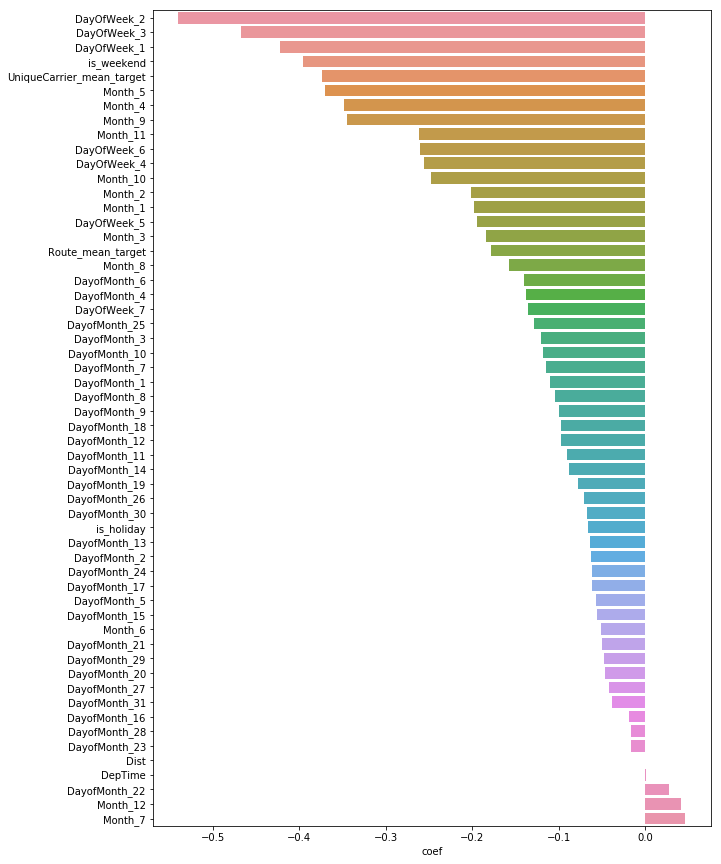

In [570]:
cf_logreg= pd.DataFrame({'coef': logreg.coef_[0]}, index=list(X_train_train.columns))
plt.figure(figsize=(10, 15))
cf_logreg = cf_logreg.sort_values('coef')
sns.barplot(y=cf_logreg.index, x=cf_logreg.coef)

In [564]:
lx = 0.5*logreg_pred + 0.5 * xgb__pred

roc_auc_score(y_train_test, lx)

0.715482771521284

In [200]:
X_train_test.shape, y_train_test.shape

((30000, 56), (30000,))

In [208]:
lr = LogisticRegression()

lr.fit(X_train_train, y_train_train)
lr_pred = lr.predict_proba(X_train_test)[:, 1]

roc_auc_score(y_train_test, lr_pred)

0.7007391784757878

In [254]:
X_train_train.columns[-23]

'DayofMonth_22'

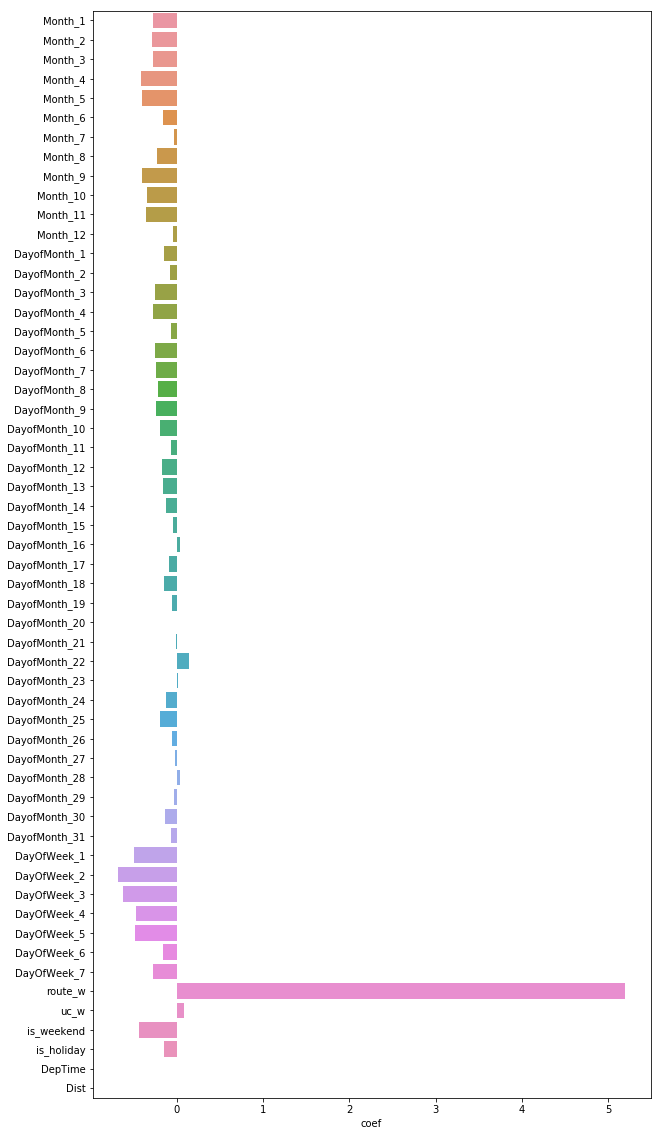

In [261]:
cf= pd.DataFrame({'coef': lr.coef_[0]}, index=list(X_train_train.columns))
plt.figure(figsize=(10, 20))
sns.barplot(y=cf.index, x=cf.coef)

In [202]:
lr.fit(train_tr, y_train)
lr_all_pred = lr.predict_proba(test_tr)[:, 1]

pd.Series(lr_all_pred, name='dep_delayed_15min').to_csv('lr_dist_dep_dummies_cuts.csv', index_label='id', header=True)

In [18]:
xgb_cl = XGBClassifier(learning_rate=0.05, n_estimators=1000, booster='gbtree', n_jobs=-1)

X_train_fn = X_train_train.copy()
X_train_fn.columns = range(X_train_train.shape[1])


X_test_fn = X_train_test.copy()
X_test_fn.columns = range(X_train_test.shape[1])

xgb_cl.fit(X_train_fn, y_train_train)

xgb_pred = xgb_cl.predict_proba(X_test_fn)[:, 1]

roc_auc_score(y_train_test, xgb_pred)

0.7301074437816706

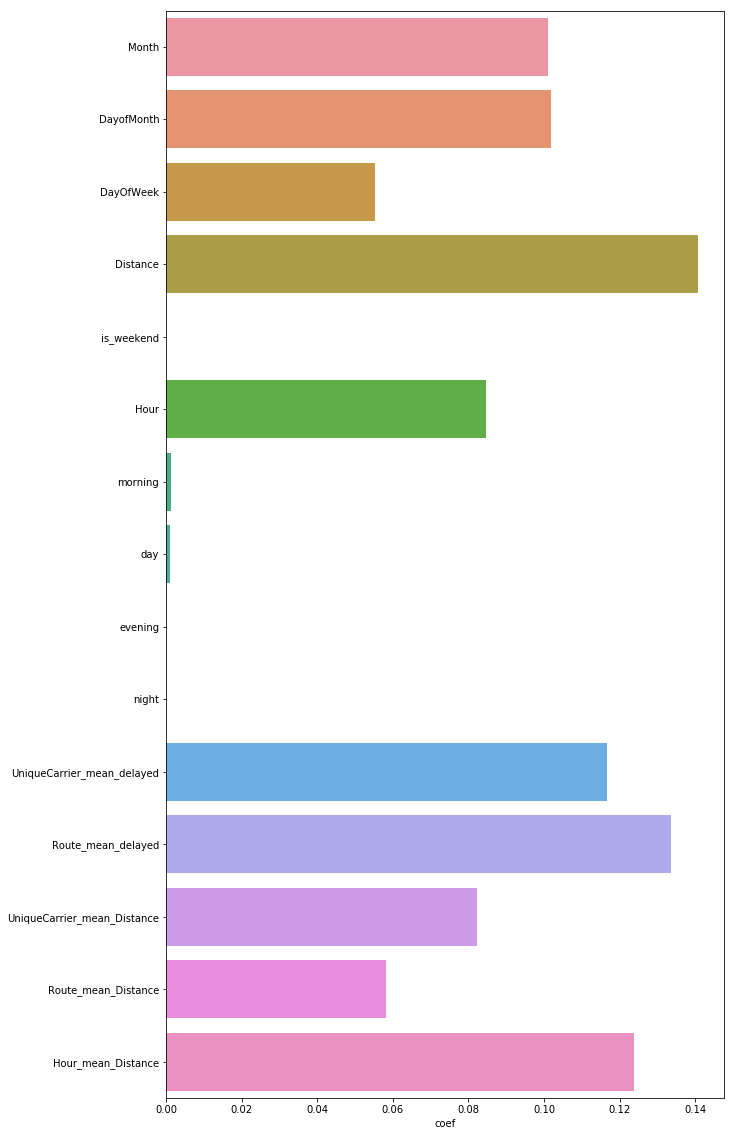

In [149]:
cf_x= pd.DataFrame({'coef': xgb_cl.feature_importances_}, index=list(X_train_train.columns))
plt.figure(figsize=(10, 20))
sns.barplot(y=cf_x.index, x=cf_x.coef)

In [289]:
xx = X_train.copy()
xx['Month'] = xx['Month'].str[2:].astype('int')
xx['DayofMonth'] = xx['DayofMonth'].str[2:].astype('int')
xx['DayOfWeek'] = xx['DayOfWeek'].str[2:].astype('int')

xx = pd.get_dummies(xx, columns=['UniqueCarrier', 'Origin', 'Dest'], prefix=['UniqueCarrier', 'Origin', 'Dest'])
xx = xx.drop(['delayed', 'interstate'], axis=1)

In [309]:
xgb_s = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, booster='gblinear', n_jobs=-1)
xx_train, xx_val, y_train_tr, y_train_val = train_test_split(xx, y_train, test_size=0.3, random_state=17)

xgb_s.fit(xx_train, y_train_tr)

xgb_pred_s = xgb_s.predict_proba(xx_val)[:, 1]

roc_auc_score(y_train_val, xgb_pred_s)

0.6803264596429182

In [291]:
xgb_ss = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, booster='gbtree', n_jobs=-1)

xgb_ss.fit(xx, y_train)

xx_t = X_train.copy()
xx_t['Month'] = xx_t['Month'].str[2:].astype('int')
xx_t['DayofMonth'] = xx_t['DayofMonth'].str[2:].astype('int')
xx_t['DayOfWeek'] = xx_t['DayOfWeek'].str[2:].astype('int')

xx_t = pd.get_dummies(xx_t, columns=['UniqueCarrier', 'Origin', 'Dest'], prefix=['UniqueCarrier', 'Origin', 'Dest'])

xgb_pred_ss = xgb_ss.predict_proba(xx_t)[:, 1]


ValueError: feature_names mismatch: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_AA', 'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO', 'UniqueCarrier_DH', 'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI', 'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT', 'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ', 'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB', 'Origin_AMA', 'Origin_ANC', 'Origin_APF', 'Origin_ASE', 'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL', 'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET', 'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM', 'Origin_BIL', 'Origin_BIS', 'Origin_BLI', 'Origin_BMI', 'Origin_BNA', 'Origin_BOI', 'Origin_BOS', 'Origin_BPT', 'Origin_BQK', 'Origin_BQN', 'Origin_BRO', 'Origin_BRW', 'Origin_BTM', 'Origin_BTR', 'Origin_BTV', 'Origin_BUF', 'Origin_BUR', 'Origin_BWI', 'Origin_BZN', 'Origin_CAE', 'Origin_CAK', 'Origin_CDC', 'Origin_CDV', 'Origin_CEC', 'Origin_CHA', 'Origin_CHO', 'Origin_CHS', 'Origin_CIC', 'Origin_CID', 'Origin_CLD', 'Origin_CLE', 'Origin_CLL', 'Origin_CLT', 'Origin_CMH', 'Origin_CMI', 'Origin_COD', 'Origin_COS', 'Origin_CPR', 'Origin_CRP', 'Origin_CRW', 'Origin_CSG', 'Origin_CVG', 'Origin_CWA', 'Origin_DAB', 'Origin_DAL', 'Origin_DAY', 'Origin_DBQ', 'Origin_DCA', 'Origin_DEN', 'Origin_DFW', 'Origin_DHN', 'Origin_DLG', 'Origin_DLH', 'Origin_DRO', 'Origin_DSM', 'Origin_DTW', 'Origin_EGE', 'Origin_EKO', 'Origin_ELP', 'Origin_ERI', 'Origin_EUG', 'Origin_EVV', 'Origin_EWR', 'Origin_EYW', 'Origin_FAI', 'Origin_FAR', 'Origin_FAT', 'Origin_FAY', 'Origin_FCA', 'Origin_FLG', 'Origin_FLL', 'Origin_FLO', 'Origin_FNT', 'Origin_FSD', 'Origin_FSM', 'Origin_FWA', 'Origin_GEG', 'Origin_GFK', 'Origin_GGG', 'Origin_GJT', 'Origin_GNV', 'Origin_GPT', 'Origin_GRB', 'Origin_GRK', 'Origin_GRR', 'Origin_GSO', 'Origin_GSP', 'Origin_GST', 'Origin_GTF', 'Origin_GTR', 'Origin_GUC', 'Origin_HDN', 'Origin_HKY', 'Origin_HLN', 'Origin_HNL', 'Origin_HOU', 'Origin_HPN', 'Origin_HRL', 'Origin_HSV', 'Origin_HTS', 'Origin_HVN', 'Origin_IAD', 'Origin_IAH', 'Origin_ICT', 'Origin_IDA', 'Origin_ILG', 'Origin_ILM', 'Origin_IND', 'Origin_IPL', 'Origin_ISO', 'Origin_ISP', 'Origin_ITO', 'Origin_IYK', 'Origin_JAC', 'Origin_JAN', 'Origin_JAX', 'Origin_JFK', 'Origin_JNU', 'Origin_KOA', 'Origin_KTN', 'Origin_LAN', 'Origin_LAS', 'Origin_LAW', 'Origin_LAX', 'Origin_LBB', 'Origin_LCH', 'Origin_LEX', 'Origin_LFT', 'Origin_LGA', 'Origin_LGB', 'Origin_LIH', 'Origin_LIT', 'Origin_LNK', 'Origin_LRD', 'Origin_LSE', 'Origin_LWB', 'Origin_LWS', 'Origin_LYH', 'Origin_MAF', 'Origin_MBS', 'Origin_MCI', 'Origin_MCN', 'Origin_MCO', 'Origin_MDT', 'Origin_MDW', 'Origin_MEI', 'Origin_MEM', 'Origin_MFE', 'Origin_MFR', 'Origin_MGM', 'Origin_MHT', 'Origin_MIA', 'Origin_MKE', 'Origin_MLB', 'Origin_MLI', 'Origin_MLU', 'Origin_MOB', 'Origin_MOD', 'Origin_MOT', 'Origin_MQT', 'Origin_MRY', 'Origin_MSN', 'Origin_MSO', 'Origin_MSP', 'Origin_MSY', 'Origin_MTJ', 'Origin_MYR', 'Origin_OAJ', 'Origin_OAK', 'Origin_OGG', 'Origin_OKC', 'Origin_OMA', 'Origin_OME', 'Origin_ONT', 'Origin_ORD', 'Origin_ORF', 'Origin_OTZ', 'Origin_OXR', 'Origin_PBI', 'Origin_PDX', 'Origin_PFN', 'Origin_PHF', 'Origin_PHL', 'Origin_PHX', 'Origin_PIA', 'Origin_PIE', 'Origin_PIH', 'Origin_PIT', 'Origin_PNS', 'Origin_PSC', 'Origin_PSE', 'Origin_PSG', 'Origin_PSP', 'Origin_PVD', 'Origin_PWM', 'Origin_RAP', 'Origin_RDD', 'Origin_RDM', 'Origin_RDU', 'Origin_RFD', 'Origin_RIC', 'Origin_RNO', 'Origin_ROA', 'Origin_ROC', 'Origin_RST', 'Origin_RSW', 'Origin_SAN', 'Origin_SAT', 'Origin_SAV', 'Origin_SBA', 'Origin_SBN', 'Origin_SBP', 'Origin_SCC', 'Origin_SCE', 'Origin_SDF', 'Origin_SEA', 'Origin_SFO', 'Origin_SGF', 'Origin_SGU', 'Origin_SHV', 'Origin_SIT', 'Origin_SJC', 'Origin_SJT', 'Origin_SJU', 'Origin_SLC', 'Origin_SMF', 'Origin_SMX', 'Origin_SNA', 'Origin_SPI', 'Origin_SPS', 'Origin_SRQ', 'Origin_STL', 'Origin_STT', 'Origin_STX', 'Origin_SUN', 'Origin_SWF', 'Origin_SYR', 'Origin_TEX', 'Origin_TLH', 'Origin_TOL', 'Origin_TPA', 'Origin_TRI', 'Origin_TUL', 'Origin_TUP', 'Origin_TUS', 'Origin_TVC', 'Origin_TWF', 'Origin_TXK', 'Origin_TYR', 'Origin_TYS', 'Origin_VCT', 'Origin_VIS', 'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YUM', 'Dest_ABE', 'Dest_ABI', 'Dest_ABQ', 'Dest_ABY', 'Dest_ACK', 'Dest_ACT', 'Dest_ACV', 'Dest_ACY', 'Dest_ADQ', 'Dest_AEX', 'Dest_AGS', 'Dest_AKN', 'Dest_ALB', 'Dest_AMA', 'Dest_ANC', 'Dest_APF', 'Dest_ASE', 'Dest_ATL', 'Dest_ATW', 'Dest_AUS', 'Dest_AVL', 'Dest_AVP', 'Dest_AZO', 'Dest_BDL', 'Dest_BET', 'Dest_BFL', 'Dest_BGM', 'Dest_BGR', 'Dest_BHM', 'Dest_BIL', 'Dest_BIS', 'Dest_BLI', 'Dest_BMI', 'Dest_BNA', 'Dest_BOI', 'Dest_BOS', 'Dest_BPT', 'Dest_BQK', 'Dest_BQN', 'Dest_BRO', 'Dest_BRW', 'Dest_BTM', 'Dest_BTR', 'Dest_BTV', 'Dest_BUF', 'Dest_BUR', 'Dest_BWI', 'Dest_BZN', 'Dest_CAE', 'Dest_CAK', 'Dest_CDC', 'Dest_CDV', 'Dest_CEC', 'Dest_CHA', 'Dest_CHO', 'Dest_CHS', 'Dest_CIC', 'Dest_CID', 'Dest_CLD', 'Dest_CLE', 'Dest_CLL', 'Dest_CLT', 'Dest_CMH', 'Dest_CMI', 'Dest_COD', 'Dest_COS', 'Dest_CPR', 'Dest_CRP', 'Dest_CRW', 'Dest_CSG', 'Dest_CVG', 'Dest_CWA', 'Dest_DAB', 'Dest_DAL', 'Dest_DAY', 'Dest_DBQ', 'Dest_DCA', 'Dest_DEN', 'Dest_DFW', 'Dest_DHN', 'Dest_DLG', 'Dest_DLH', 'Dest_DRO', 'Dest_DSM', 'Dest_DTW', 'Dest_EGE', 'Dest_EKO', 'Dest_ELP', 'Dest_ERI', 'Dest_EUG', 'Dest_EVV', 'Dest_EWR', 'Dest_EYW', 'Dest_FAI', 'Dest_FAR', 'Dest_FAT', 'Dest_FAY', 'Dest_FCA', 'Dest_FLG', 'Dest_FLL', 'Dest_FLO', 'Dest_FNT', 'Dest_FSD', 'Dest_FSM', 'Dest_FWA', 'Dest_GEG', 'Dest_GFK', 'Dest_GGG', 'Dest_GJT', 'Dest_GNV', 'Dest_GPT', 'Dest_GRB', 'Dest_GRK', 'Dest_GRR', 'Dest_GSO', 'Dest_GSP', 'Dest_GST', 'Dest_GTF', 'Dest_GTR', 'Dest_GUC', 'Dest_HDN', 'Dest_HKY', 'Dest_HLN', 'Dest_HNL', 'Dest_HOU', 'Dest_HPN', 'Dest_HRL', 'Dest_HSV', 'Dest_HTS', 'Dest_HVN', 'Dest_IAD', 'Dest_IAH', 'Dest_ICT', 'Dest_IDA', 'Dest_ILG', 'Dest_ILM', 'Dest_IND', 'Dest_IPL', 'Dest_ISO', 'Dest_ISP', 'Dest_ITO', 'Dest_IYK', 'Dest_JAC', 'Dest_JAN', 'Dest_JAX', 'Dest_JFK', 'Dest_JNU', 'Dest_KOA', 'Dest_KTN', 'Dest_LAN', 'Dest_LAS', 'Dest_LAW', 'Dest_LAX', 'Dest_LBB', 'Dest_LCH', 'Dest_LEX', 'Dest_LFT', 'Dest_LGA', 'Dest_LGB', 'Dest_LIH', 'Dest_LIT', 'Dest_LNK', 'Dest_LRD', 'Dest_LSE', 'Dest_LWB', 'Dest_LWS', 'Dest_LYH', 'Dest_MAF', 'Dest_MBS', 'Dest_MCI', 'Dest_MCN', 'Dest_MCO', 'Dest_MDT', 'Dest_MDW', 'Dest_MEI', 'Dest_MEM', 'Dest_MFE', 'Dest_MFR', 'Dest_MGM', 'Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MLB', 'Dest_MLI', 'Dest_MLU', 'Dest_MOB', 'Dest_MOD', 'Dest_MOT', 'Dest_MQT', 'Dest_MRY', 'Dest_MSN', 'Dest_MSO', 'Dest_MSP', 'Dest_MSY', 'Dest_MTJ', 'Dest_MYR', 'Dest_OAK', 'Dest_OGG', 'Dest_OKC', 'Dest_OMA', 'Dest_OME', 'Dest_ONT', 'Dest_ORD', 'Dest_ORF', 'Dest_OTZ', 'Dest_OXR', 'Dest_PBI', 'Dest_PDX', 'Dest_PFN', 'Dest_PHF', 'Dest_PHL', 'Dest_PHX', 'Dest_PIA', 'Dest_PIE', 'Dest_PIH', 'Dest_PIT', 'Dest_PNS', 'Dest_PSC', 'Dest_PSE', 'Dest_PSG', 'Dest_PSP', 'Dest_PVD', 'Dest_PWM', 'Dest_RAP', 'Dest_RDD', 'Dest_RDM', 'Dest_RDU', 'Dest_RFD', 'Dest_RIC', 'Dest_RNO', 'Dest_ROA', 'Dest_ROC', 'Dest_RST', 'Dest_RSW', 'Dest_SAN', 'Dest_SAT', 'Dest_SAV', 'Dest_SBA', 'Dest_SBN', 'Dest_SBP', 'Dest_SCC', 'Dest_SCE', 'Dest_SDF', 'Dest_SEA', 'Dest_SFO', 'Dest_SGF', 'Dest_SGU', 'Dest_SHV', 'Dest_SIT', 'Dest_SJC', 'Dest_SJT', 'Dest_SJU', 'Dest_SLC', 'Dest_SMF', 'Dest_SMX', 'Dest_SNA', 'Dest_SOP', 'Dest_SPI', 'Dest_SPS', 'Dest_SRQ', 'Dest_STL', 'Dest_STT', 'Dest_STX', 'Dest_SUN', 'Dest_SWF', 'Dest_SYR', 'Dest_TEX', 'Dest_TLH', 'Dest_TOL', 'Dest_TPA', 'Dest_TRI', 'Dest_TTN', 'Dest_TUL', 'Dest_TUP', 'Dest_TUS', 'Dest_TVC', 'Dest_TWF', 'Dest_TXK', 'Dest_TYR', 'Dest_TYS', 'Dest_VCT', 'Dest_VIS', 'Dest_VLD', 'Dest_VPS', 'Dest_WRG', 'Dest_WYS', 'Dest_XNA', 'Dest_YAK', 'Dest_YUM'] ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'delayed', 'interstate', 'UniqueCarrier_AA', 'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO', 'UniqueCarrier_DH', 'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI', 'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT', 'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ', 'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB', 'Origin_AMA', 'Origin_ANC', 'Origin_APF', 'Origin_ASE', 'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL', 'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET', 'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM', 'Origin_BIL', 'Origin_BIS', 'Origin_BLI', 'Origin_BMI', 'Origin_BNA', 'Origin_BOI', 'Origin_BOS', 'Origin_BPT', 'Origin_BQK', 'Origin_BQN', 'Origin_BRO', 'Origin_BRW', 'Origin_BTM', 'Origin_BTR', 'Origin_BTV', 'Origin_BUF', 'Origin_BUR', 'Origin_BWI', 'Origin_BZN', 'Origin_CAE', 'Origin_CAK', 'Origin_CDC', 'Origin_CDV', 'Origin_CEC', 'Origin_CHA', 'Origin_CHO', 'Origin_CHS', 'Origin_CIC', 'Origin_CID', 'Origin_CLD', 'Origin_CLE', 'Origin_CLL', 'Origin_CLT', 'Origin_CMH', 'Origin_CMI', 'Origin_COD', 'Origin_COS', 'Origin_CPR', 'Origin_CRP', 'Origin_CRW', 'Origin_CSG', 'Origin_CVG', 'Origin_CWA', 'Origin_DAB', 'Origin_DAL', 'Origin_DAY', 'Origin_DBQ', 'Origin_DCA', 'Origin_DEN', 'Origin_DFW', 'Origin_DHN', 'Origin_DLG', 'Origin_DLH', 'Origin_DRO', 'Origin_DSM', 'Origin_DTW', 'Origin_EGE', 'Origin_EKO', 'Origin_ELP', 'Origin_ERI', 'Origin_EUG', 'Origin_EVV', 'Origin_EWR', 'Origin_EYW', 'Origin_FAI', 'Origin_FAR', 'Origin_FAT', 'Origin_FAY', 'Origin_FCA', 'Origin_FLG', 'Origin_FLL', 'Origin_FLO', 'Origin_FNT', 'Origin_FSD', 'Origin_FSM', 'Origin_FWA', 'Origin_GEG', 'Origin_GFK', 'Origin_GGG', 'Origin_GJT', 'Origin_GNV', 'Origin_GPT', 'Origin_GRB', 'Origin_GRK', 'Origin_GRR', 'Origin_GSO', 'Origin_GSP', 'Origin_GST', 'Origin_GTF', 'Origin_GTR', 'Origin_GUC', 'Origin_HDN', 'Origin_HKY', 'Origin_HLN', 'Origin_HNL', 'Origin_HOU', 'Origin_HPN', 'Origin_HRL', 'Origin_HSV', 'Origin_HTS', 'Origin_HVN', 'Origin_IAD', 'Origin_IAH', 'Origin_ICT', 'Origin_IDA', 'Origin_ILG', 'Origin_ILM', 'Origin_IND', 'Origin_IPL', 'Origin_ISO', 'Origin_ISP', 'Origin_ITO', 'Origin_IYK', 'Origin_JAC', 'Origin_JAN', 'Origin_JAX', 'Origin_JFK', 'Origin_JNU', 'Origin_KOA', 'Origin_KTN', 'Origin_LAN', 'Origin_LAS', 'Origin_LAW', 'Origin_LAX', 'Origin_LBB', 'Origin_LCH', 'Origin_LEX', 'Origin_LFT', 'Origin_LGA', 'Origin_LGB', 'Origin_LIH', 'Origin_LIT', 'Origin_LNK', 'Origin_LRD', 'Origin_LSE', 'Origin_LWB', 'Origin_LWS', 'Origin_LYH', 'Origin_MAF', 'Origin_MBS', 'Origin_MCI', 'Origin_MCN', 'Origin_MCO', 'Origin_MDT', 'Origin_MDW', 'Origin_MEI', 'Origin_MEM', 'Origin_MFE', 'Origin_MFR', 'Origin_MGM', 'Origin_MHT', 'Origin_MIA', 'Origin_MKE', 'Origin_MLB', 'Origin_MLI', 'Origin_MLU', 'Origin_MOB', 'Origin_MOD', 'Origin_MOT', 'Origin_MQT', 'Origin_MRY', 'Origin_MSN', 'Origin_MSO', 'Origin_MSP', 'Origin_MSY', 'Origin_MTJ', 'Origin_MYR', 'Origin_OAJ', 'Origin_OAK', 'Origin_OGG', 'Origin_OKC', 'Origin_OMA', 'Origin_OME', 'Origin_ONT', 'Origin_ORD', 'Origin_ORF', 'Origin_OTZ', 'Origin_OXR', 'Origin_PBI', 'Origin_PDX', 'Origin_PFN', 'Origin_PHF', 'Origin_PHL', 'Origin_PHX', 'Origin_PIA', 'Origin_PIE', 'Origin_PIH', 'Origin_PIT', 'Origin_PNS', 'Origin_PSC', 'Origin_PSE', 'Origin_PSG', 'Origin_PSP', 'Origin_PVD', 'Origin_PWM', 'Origin_RAP', 'Origin_RDD', 'Origin_RDM', 'Origin_RDU', 'Origin_RFD', 'Origin_RIC', 'Origin_RNO', 'Origin_ROA', 'Origin_ROC', 'Origin_RST', 'Origin_RSW', 'Origin_SAN', 'Origin_SAT', 'Origin_SAV', 'Origin_SBA', 'Origin_SBN', 'Origin_SBP', 'Origin_SCC', 'Origin_SCE', 'Origin_SDF', 'Origin_SEA', 'Origin_SFO', 'Origin_SGF', 'Origin_SGU', 'Origin_SHV', 'Origin_SIT', 'Origin_SJC', 'Origin_SJT', 'Origin_SJU', 'Origin_SLC', 'Origin_SMF', 'Origin_SMX', 'Origin_SNA', 'Origin_SPI', 'Origin_SPS', 'Origin_SRQ', 'Origin_STL', 'Origin_STT', 'Origin_STX', 'Origin_SUN', 'Origin_SWF', 'Origin_SYR', 'Origin_TEX', 'Origin_TLH', 'Origin_TOL', 'Origin_TPA', 'Origin_TRI', 'Origin_TUL', 'Origin_TUP', 'Origin_TUS', 'Origin_TVC', 'Origin_TWF', 'Origin_TXK', 'Origin_TYR', 'Origin_TYS', 'Origin_VCT', 'Origin_VIS', 'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YUM', 'Dest_ABE', 'Dest_ABI', 'Dest_ABQ', 'Dest_ABY', 'Dest_ACK', 'Dest_ACT', 'Dest_ACV', 'Dest_ACY', 'Dest_ADQ', 'Dest_AEX', 'Dest_AGS', 'Dest_AKN', 'Dest_ALB', 'Dest_AMA', 'Dest_ANC', 'Dest_APF', 'Dest_ASE', 'Dest_ATL', 'Dest_ATW', 'Dest_AUS', 'Dest_AVL', 'Dest_AVP', 'Dest_AZO', 'Dest_BDL', 'Dest_BET', 'Dest_BFL', 'Dest_BGM', 'Dest_BGR', 'Dest_BHM', 'Dest_BIL', 'Dest_BIS', 'Dest_BLI', 'Dest_BMI', 'Dest_BNA', 'Dest_BOI', 'Dest_BOS', 'Dest_BPT', 'Dest_BQK', 'Dest_BQN', 'Dest_BRO', 'Dest_BRW', 'Dest_BTM', 'Dest_BTR', 'Dest_BTV', 'Dest_BUF', 'Dest_BUR', 'Dest_BWI', 'Dest_BZN', 'Dest_CAE', 'Dest_CAK', 'Dest_CDC', 'Dest_CDV', 'Dest_CEC', 'Dest_CHA', 'Dest_CHO', 'Dest_CHS', 'Dest_CIC', 'Dest_CID', 'Dest_CLD', 'Dest_CLE', 'Dest_CLL', 'Dest_CLT', 'Dest_CMH', 'Dest_CMI', 'Dest_COD', 'Dest_COS', 'Dest_CPR', 'Dest_CRP', 'Dest_CRW', 'Dest_CSG', 'Dest_CVG', 'Dest_CWA', 'Dest_DAB', 'Dest_DAL', 'Dest_DAY', 'Dest_DBQ', 'Dest_DCA', 'Dest_DEN', 'Dest_DFW', 'Dest_DHN', 'Dest_DLG', 'Dest_DLH', 'Dest_DRO', 'Dest_DSM', 'Dest_DTW', 'Dest_EGE', 'Dest_EKO', 'Dest_ELP', 'Dest_ERI', 'Dest_EUG', 'Dest_EVV', 'Dest_EWR', 'Dest_EYW', 'Dest_FAI', 'Dest_FAR', 'Dest_FAT', 'Dest_FAY', 'Dest_FCA', 'Dest_FLG', 'Dest_FLL', 'Dest_FLO', 'Dest_FNT', 'Dest_FSD', 'Dest_FSM', 'Dest_FWA', 'Dest_GEG', 'Dest_GFK', 'Dest_GGG', 'Dest_GJT', 'Dest_GNV', 'Dest_GPT', 'Dest_GRB', 'Dest_GRK', 'Dest_GRR', 'Dest_GSO', 'Dest_GSP', 'Dest_GST', 'Dest_GTF', 'Dest_GTR', 'Dest_GUC', 'Dest_HDN', 'Dest_HKY', 'Dest_HLN', 'Dest_HNL', 'Dest_HOU', 'Dest_HPN', 'Dest_HRL', 'Dest_HSV', 'Dest_HTS', 'Dest_HVN', 'Dest_IAD', 'Dest_IAH', 'Dest_ICT', 'Dest_IDA', 'Dest_ILG', 'Dest_ILM', 'Dest_IND', 'Dest_IPL', 'Dest_ISO', 'Dest_ISP', 'Dest_ITO', 'Dest_IYK', 'Dest_JAC', 'Dest_JAN', 'Dest_JAX', 'Dest_JFK', 'Dest_JNU', 'Dest_KOA', 'Dest_KTN', 'Dest_LAN', 'Dest_LAS', 'Dest_LAW', 'Dest_LAX', 'Dest_LBB', 'Dest_LCH', 'Dest_LEX', 'Dest_LFT', 'Dest_LGA', 'Dest_LGB', 'Dest_LIH', 'Dest_LIT', 'Dest_LNK', 'Dest_LRD', 'Dest_LSE', 'Dest_LWB', 'Dest_LWS', 'Dest_LYH', 'Dest_MAF', 'Dest_MBS', 'Dest_MCI', 'Dest_MCN', 'Dest_MCO', 'Dest_MDT', 'Dest_MDW', 'Dest_MEI', 'Dest_MEM', 'Dest_MFE', 'Dest_MFR', 'Dest_MGM', 'Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MLB', 'Dest_MLI', 'Dest_MLU', 'Dest_MOB', 'Dest_MOD', 'Dest_MOT', 'Dest_MQT', 'Dest_MRY', 'Dest_MSN', 'Dest_MSO', 'Dest_MSP', 'Dest_MSY', 'Dest_MTJ', 'Dest_MYR', 'Dest_OAK', 'Dest_OGG', 'Dest_OKC', 'Dest_OMA', 'Dest_OME', 'Dest_ONT', 'Dest_ORD', 'Dest_ORF', 'Dest_OTZ', 'Dest_OXR', 'Dest_PBI', 'Dest_PDX', 'Dest_PFN', 'Dest_PHF', 'Dest_PHL', 'Dest_PHX', 'Dest_PIA', 'Dest_PIE', 'Dest_PIH', 'Dest_PIT', 'Dest_PNS', 'Dest_PSC', 'Dest_PSE', 'Dest_PSG', 'Dest_PSP', 'Dest_PVD', 'Dest_PWM', 'Dest_RAP', 'Dest_RDD', 'Dest_RDM', 'Dest_RDU', 'Dest_RFD', 'Dest_RIC', 'Dest_RNO', 'Dest_ROA', 'Dest_ROC', 'Dest_RST', 'Dest_RSW', 'Dest_SAN', 'Dest_SAT', 'Dest_SAV', 'Dest_SBA', 'Dest_SBN', 'Dest_SBP', 'Dest_SCC', 'Dest_SCE', 'Dest_SDF', 'Dest_SEA', 'Dest_SFO', 'Dest_SGF', 'Dest_SGU', 'Dest_SHV', 'Dest_SIT', 'Dest_SJC', 'Dest_SJT', 'Dest_SJU', 'Dest_SLC', 'Dest_SMF', 'Dest_SMX', 'Dest_SNA', 'Dest_SOP', 'Dest_SPI', 'Dest_SPS', 'Dest_SRQ', 'Dest_STL', 'Dest_STT', 'Dest_STX', 'Dest_SUN', 'Dest_SWF', 'Dest_SYR', 'Dest_TEX', 'Dest_TLH', 'Dest_TOL', 'Dest_TPA', 'Dest_TRI', 'Dest_TTN', 'Dest_TUL', 'Dest_TUP', 'Dest_TUS', 'Dest_TVC', 'Dest_TWF', 'Dest_TXK', 'Dest_TYR', 'Dest_TYS', 'Dest_VCT', 'Dest_VIS', 'Dest_VLD', 'Dest_VPS', 'Dest_WRG', 'Dest_WYS', 'Dest_XNA', 'Dest_YAK', 'Dest_YUM']
training data did not have the following fields: interstate, delayed

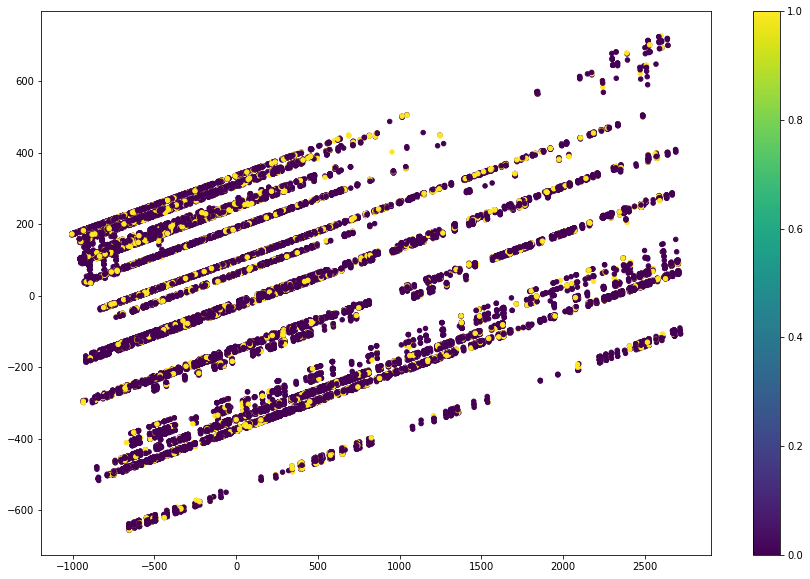

In [150]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_train_pca = pca.fit_transform(X_train_train)
plt.figure(figsize=(15, 10))
plt.scatter(X_train_train_pca[:, 0], X_train_train_pca[:, 1], c=y_train_train, s=20, cmap='viridis')
plt.colorbar()

In [213]:

X_train_all_fn = train_tr_w.copy()
X_train_all_fn.columns = range(train_tr_w.shape[1])


X_test_all_fn = test_tr_w.copy()
X_test_all_fn.columns = range(test_tr_w.shape[1])

xgb_cl.fit(X_train_all_fn, y_train)

xgb_all_pred = xgb_cl.predict_proba(X_test_all_fn)[:, 1]


pd.Series(xgb_all_pred, name='dep_delayed_15min').to_csv('xgb_no_dumm_hour_mins_y_means.csv', index_label='id', header=True)

In [307]:
(xgb_all_pred - pd.read_csv('xgb_3_1000_0.1_0.044_pred.csv')['dep_delayed_15min']).mean()

0.009937064145160119

In [265]:
from sklearn.ensemble import RandomForestClassifier

dt_cl = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1, class_weight='balanced')

dt_cl.fit(X_train_train, y_train_train)

dt_pred = dt_cl.predict_proba(X_train_test)[:, 1]

roc_auc_score(y_train_test, dt_pred)

0.7111499966123014

In [302]:
ws = [[1.],
    [0.5, 0.2, 0.3],
      [0.6, 0.2, 0.2],
     [0.4, 0.2, 0.4],
     [0.3, 0.25, 0.45],
     [0.3, 0.5, 0.2],
     [0.2, 0.6, 0.2],
     [0.2, 0.45, 0.35],
     [0.3, 0.45, 0.25],
     [0.2, 0.5, 0.3],
     [0.2, 0.3, 0.5],
     [0.3, 0.2, 0.5],
     [0.2, 0.2, 0.6]]

wts = np.linspace(0.2, 0.89, 20)
for w in wts:
    pred_w =  + w * xgb_pred + (1-w)*lr_pred
    print(w)
    print(roc_auc_score(y_train_test, pred_w))
    print('-----------------------')
# tr_t_pred_w = 0.37*dt_pred + 0.27 * xgb_pred + 0.37*lr_pred
# roc_auc_score(y_train_test, tr_t_pred_w)

0.2
0.7584858815543774
-----------------------
0.23631578947368423
0.7601505174445184
-----------------------
0.27263157894736845
0.7616472266435462
-----------------------
0.30894736842105264
0.7629898495025034
-----------------------
0.3452631578947368
0.7641990595017221
-----------------------
0.3815789473684211
0.7652817260397536
-----------------------
0.41789473684210526
0.7662490200498304
-----------------------
0.4542105263157895
0.767121600504578
-----------------------
0.4905263157894737
0.7679030362995486
-----------------------
0.5268421052631579
0.7685990942476766
-----------------------
0.5631578947368421
0.7692234043382754
-----------------------
0.5994736842105264
0.7697805727678398
-----------------------
0.6357894736842105
0.7702825248702876
-----------------------
0.6721052631578948
0.7707169436036524
-----------------------
0.7084210526315791
0.7710971615492852
-----------------------
0.7447368421052631
0.7714173175941654
-----------------------
0.7810526315789474
0

In [228]:
tr_t_pred_mean = np.mean([dt_pred, xgb_pred, lr_pred], axis=0)

roc_auc_score(y_train_test, tr_t_pred_mean)

0.7707134835158915

In [212]:

dt_cl.fit(X_train_all_fn, y_train)

dt_cl_all_pred = dt_cl.predict_proba(X_test_all_fn)[:, 1]


pd.Series(dt_cl_all_pred, name='dep_delayed_15min').to_csv('rf_5_500_dist_dep_dummies_cuts.csv', index_label='id', header=True)

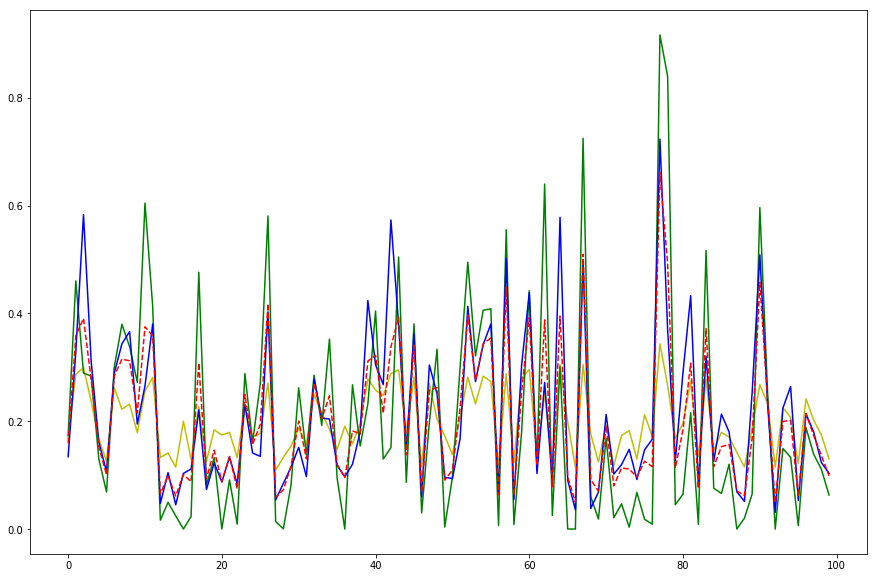

In [223]:
f, axx = plt.subplots(ncols=1, figsize=(15, 10))
axx.plot(dt_cl_all_pred[-100:], 'y')
axx.plot(xgb_all_pred[-100:], 'g')
axx.plot(lr_all_pred[-100:], 'b')
axx.plot(np.mean([dt_cl_all_pred[-100:], xgb_all_pred[-100:], lr_all_pred[-100:]], axis=0), 'r--')

In [225]:
xgb_rf_lr_mean = np.mean([dt_cl_all_pred, xgb_all_pred, lr_all_pred], axis=0)

pd.Series(xgb_rf_lr_mean, name='dep_delayed_15min').to_csv('ens_rf5_500_lr_xgb_dist_dep_dummies_cuts.csv', index_label='id', header=True)

In [299]:
w = 0.5511333333333333
xgb_rf_lr_mean = w*xgb_all_pred + (1-w)*lr_all_pred

pd.Series(xgb_rf_lr_mean, name='dep_delayed_15min').to_csv('w_lr_xgb_dist_dep_dummies_cuts.csv', index_label='id', header=True)

In [143]:
np.logspace(-3, 0.3, 5)

array([1.00000000e-03, 6.68343918e-03, 4.46683592e-02, 2.98538262e-01,
       1.99526231e+00])

In [48]:
xgb_params = {'max_depth': [1, 3, 5, 7, 10],
             'learning_rate': [0.01, 0.05, 0.1],
             'reg_lambda': [0.5, 1, 10, 20, 50],
             'n_estimators': [100, 300, 500]} 

stf = StratifiedKFold(3)
gs_x = GridSearchCV(xgb_cl, xgb_params, scoring='roc_auc', cv=stf, verbose=2, n_jobs=-1)

In [ ]:
gs_x.fit(X_train_fn, y_train_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min


In [170]:
gs_x.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 0.2}

In [171]:
train_score = np.vstack([gs_x.cv_results_['split0_train_score'], gs_x.cv_results_['split1_train_score'],gs_x.cv_results_['split2_train_score'], gs_x.cv_results_['split3_train_score']])
test_score = np.vstack([gs_x.cv_results_['split0_test_score'], gs_x.cv_results_['split1_test_score'],gs_x.cv_results_['split2_test_score'], gs_x.cv_results_['split3_test_score']])


In [172]:
ts = gs_x.cv_results_['mean_test_score']
s_idx = sorted(range(len(ts)), key=lambda k: ts[k])[-10:]

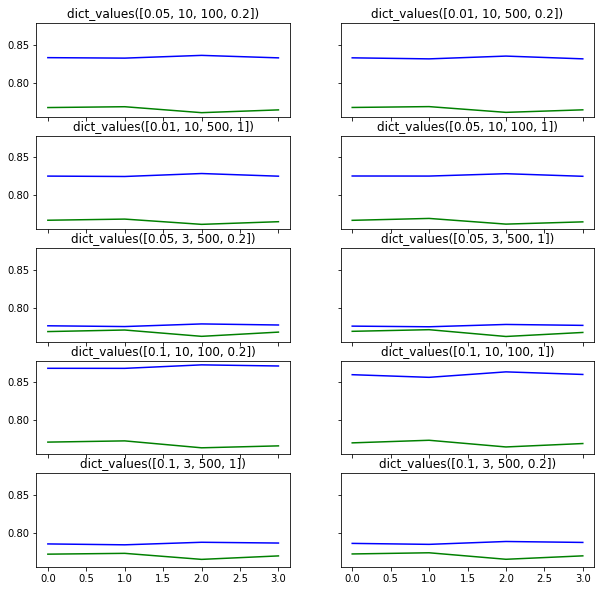

In [173]:


f, axarr = plt.subplots(ncols=2, nrows=5, sharex=True, sharey=True, figsize=(10, 10))
j = 0
for i in s_idx:
    axarr[int(j / 2), j % 2].plot(train_score[:, i], 'b')
    axarr[int(j / 2), j % 2].plot(test_score[:, i], 'g')
    axarr[int(j / 2), j % 2].set_title(str(gs_x.cv_results_['params'][i].values()))
    j+= 1
    

In [212]:
xgb_cl_all = XGBClassifier(max_depth=3, n_estimators=1000, reg_lambda=0.1, learning_rate=np.logspace(-3, 0.3, 3)[1], booster='gbtree', n_jobs=-1)

xgb_cl_all.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0446683592150963,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0446683592150963,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)>

In [228]:
_, st = prepare_data(train, 5000)
test_tr, _ = prepare_data(test, 5000, False)
test_tr[['Month', 'DayofMonth', 'DayOfWeek', 'hour', 'route_hash', 'Distance']] = st.transform(test_tr[['Month', 'DayofMonth', 'DayOfWeek', 'hour', 'route_hash', 'Distance']])

In [246]:
xr = np.zeros(test_tr.shape[0])
test_tr['UC_HP'], test_tr['UC_TZ'], test_tr['UC_DH' ] = xr, xr, xr
# test_tr.drop(['UC_9E'], axis=1, inplace=True)
xgb_pred_all = xgb_cl_all.predict_proba(test_tr[['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'is_weekend', 'hour', 'morning', 'day', 'evening', 'night', 'route_hash', 'UC_AA', 'UC_AQ', 'UC_AS', 'UC_B6', 'UC_CO', 'UC_DH', 'UC_DL', 'UC_EV', 'UC_F9', 'UC_FL', 'UC_HA', 'UC_HP', 'UC_MQ', 'UC_NW', 'UC_OH', 'UC_OO', 'UC_TZ', 'UC_UA', 'UC_US', 'UC_WN', 'UC_XE', 'UC_YV']])[:, 1]


pd.Series(xgb_pred_all, name='dep_delayed_15min').to_csv('xgb_3_1000_0.1_0.044_pred.csv', index_label='id', header=True)

In [247]:
gs_pred = gs_x.predict_proba(test_tr[['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'is_weekend', 'hour', 'morning', 'day', 'evening', 'night', 'route_hash', 'UC_AA', 'UC_AQ', 'UC_AS', 'UC_B6', 'UC_CO', 'UC_DH', 'UC_DL', 'UC_EV', 'UC_F9', 'UC_FL', 'UC_HA', 'UC_HP', 'UC_MQ', 'UC_NW', 'UC_OH', 'UC_OO', 'UC_TZ', 'UC_UA', 'UC_US', 'UC_WN', 'UC_XE', 'UC_YV']])[:, 1]

pd.Series(gs_pred, name='dep_delayed_15min').to_csv('gs_pred.csv', index_label='id', header=True)

In [245]:
f1 =['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'is_weekend', 'hour', 'morning', 'day', 'evening', 'night', 'route_hash', 'UC_AA', 'UC_AQ', 'UC_AS', 'UC_B6', 'UC_CO', 'UC_DH', 'UC_DL', 'UC_EV', 'UC_F9', 'UC_FL', 'UC_HA', 'UC_HP', 'UC_MQ', 'UC_NW', 'UC_OH', 'UC_OO', 'UC_TZ', 'UC_UA', 'UC_US', 'UC_WN', 'UC_XE', 'UC_YV']
f2 = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'is_weekend', 'hour', 'morning', 'day', 'evening', 'night', 'route_hash', 'UC_AA', 'UC_AQ', 'UC_AS', 'UC_B6', 'UC_CO', 'UC_DL', 'UC_EV', 'UC_F9', 'UC_FL', 'UC_HA', 'UC_MQ', 'UC_NW', 'UC_OH', 'UC_OO', 'UC_UA', 'UC_US', 'UC_WN', 'UC_XE', 'UC_YV', 'UC_HP', 'UC_TZ', 'UC_DH']

len(f1), len(f2), train_tr.columns

(33,
 33,
 Index(['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'is_weekend', 'hour',
        'morning', 'day', 'evening', 'night', 'route_hash', 'UC_AA', 'UC_AQ',
        'UC_AS', 'UC_B6', 'UC_CO', 'UC_DH', 'UC_DL', 'UC_EV', 'UC_F9', 'UC_FL',
        'UC_HA', 'UC_HP', 'UC_MQ', 'UC_NW', 'UC_OH', 'UC_OO', 'UC_TZ', 'UC_UA',
        'UC_US', 'UC_WN', 'UC_XE', 'UC_YV', 'delayed'],
       dtype='object'))

Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!